<p align="center">
  <img src="../data/uach.png" alt="UACh" width="180">
</p>

# Hito 2 — Prototipo de Convolución

Proyecto ACUS220 · Acústica Computacional con Python

Este notebook implementa un prototipo funcional para auralización por convolución con una librería de presets de respuestas al impulso (IR). Permite generar una señal de entrada (o cargar una), seleccionar una IR (salas y un modelo escalonado tipo ‘Quetzal’), aplicar filtros simples y escuchar/visualizar el resultado, además de exportar a WAV.

**Integrantes:** Carlos Duarte, Fernando Castillo, Vicente Alves, Antonio Duque

## 1. Introducción

### 1.1 Problema

El fenómeno acústico observado en la Pirámide de Kukulkán en Chichén Itzá, México, constituye un caso único de transformación del sonido debido a la geometría arquitectónica. Cuando se produce un aplauso frente a la escalinata de la pirámide, el eco resultante adquiere un carácter tonal que asemeja el canto del ave quetzal, sagrada para la cultura maya.

Este efecto, conocido como "chirp" o "eco del quetzal", es producto de las reflexiones secuenciales en los escalones de la pirámide. Cada escalón actúa como una fuente secundaria que introduce un retardo temporal específico, generando una serie de reflexiones con espaciamiento regular que modula el contenido espectral del impulso original.

**Problemática principal:**  
- ¿Cómo podemos modelar y replicar este fenómeno mediante procesamiento digital de señales?  
- ¿Qué características de la señal de entrada y la respuesta al impulso son determinantes para reproducir el efecto?  
- ¿Es posible diseñar estructuras sintéticas que generen transformaciones acústicas similares?

### 1.2 Herramienta de convolución

La **convolución** es la operación matemática fundamental para el análisis de sistemas lineales e invariantes en el tiempo (LTI). En el contexto acústico, permite calcular la salida de un sistema cuando conocemos:

- **x(t)**: Señal de entrada (por ejemplo, un aplauso)  
- **h(t)**: Respuesta al impulso (IR) del sistema (características acústicas del espacio)

La salida del sistema se obtiene mediante:

$$ y(t) = x(t) * h(t) = \int_{-\infty}^{\infty} x(\tau) \cdot h(t-\tau) \, d\tau $$

En el dominio discreto (procesamiento digital):

$$ y[n] = \sum_{k=-\infty}^{\infty} x[k] \cdot h[n-k] $$

**Implementación práctica:**  
Para señales de duración finita, es más eficiente usar la **FFT (Fast Fourier Transform)** y el teorema de convolución:

$$ y(t) = x(t) * h(t) \quad \Leftrightarrow \quad Y(f) = X(f) \cdot H(f) $$

Donde el producto en el dominio de la frecuencia equivale a la convolución en el dominio del tiempo.

### 1.3 Objetivos de este análisis

**Objetivo General:**  
Desarrollar e implementar un prototipo funcional de auralización por convolución que permita simular el efecto acústico de la Pirámide de Chichén Itzá y otros espacios de interés.

**Objetivos Específicos:**

1. **OE1 - Implementación:** Desarrollar funciones en Python para:
   - Generar señales de prueba (aplauso sintético, barridos senoidales)
   - Cargar y procesar respuestas al impulso
   - Aplicar convolución FFT con normalización
   - Implementar filtros básicos (pasa-bajos, pasa-altos, pasa-banda)

2. **OE2 - Análisis:** Caracterizar las señales mediante:
   - Visualización de formas de onda
   - Análisis espectral (espectrogramas, espectro de magnitud)
   - Métricas temporales y frecuenciales

3. **OE3 - Modelado:** Crear una librería de respuestas al impulso:
   - Salas de diferentes tamaños (pequeña, mediana, grande)
   - Modelo sintético de estructura escalonada (simulación pirámide)
   - Utilizar pyroomacoustics para simulación de espacios

4. **OE4 - Validación:** Comparar resultados simulados con:
   - Grabaciones de referencia
   - Análisis perceptual del efecto generado
   - Discusión de limitaciones físicas del modelo

## 2. Análisis preliminar

### 2.1 Generación de señales de prueba

Para evaluar el comportamiento de las respuestas al impulso, generamos tres tipos de señales de entrada:

1. **Aplauso sintético**: Señal impulsiva que simula un aplauso mediante ruido blanco con envolvente exponencial. Es la señal más representativa para este estudio, ya que el fenómeno original se produce con aplausos.

2. **Barrido senoidal (chirp)**: Señal que varía linealmente en frecuencia de 20 Hz a 12 kHz. Útil para analizar la respuesta del sistema en todo el rango audible.

3. **Audio personalizado**: Posibilidad de cargar archivos WAV externos para experimentar con diferentes fuentes sonoras.

A continuación, generamos y visualizamos un aplauso sintético para caracterizar sus propiedades:


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import librosa
import librosa.display
from IPython.display import Audio, display

In [2]:
# Función para generar aplauso sintético
def make_synthetic_clap(sr=48000, duration=0.5):
    """
    Genera un aplauso sintético breve simulando un pulso aleatorio amortiguado.
    """
    t = np.linspace(0, duration, int(sr * duration), endpoint=False)
    # Pulso tipo ruido blanco modulado exponencialmente
    clap = np.random.randn(len(t)) * np.exp(-10 * t)
    # Normalizar
    clap /= np.max(np.abs(clap))
    return clap


# Graficar forma de onda
def plot_waveform(signal, sr, title='Forma de onda'):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(signal, sr=sr)
    plt.title(title)
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud")
    plt.show()

# Graficar espectrograma
def plot_spectrogram(signal, sr, title='Espectrograma'):
    S = np.abs(librosa.stft(signal))
    S_dB = librosa.amplitude_to_db(S, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

Señal de prueba: Aplauso sintético


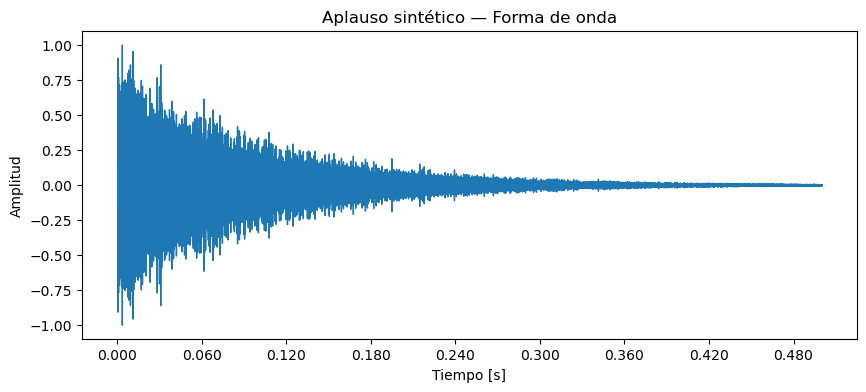

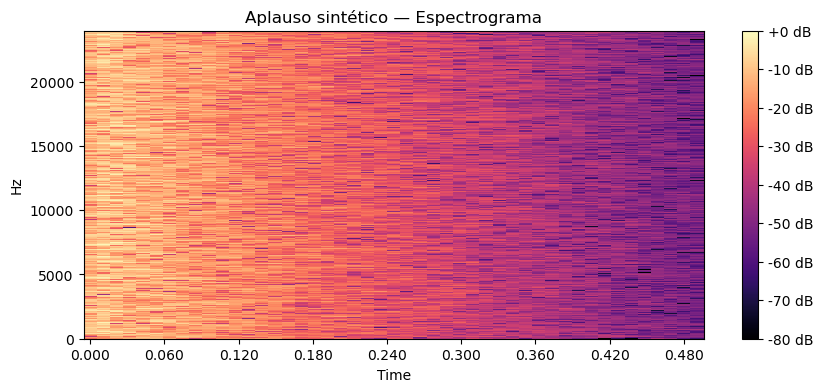

In [4]:
# Generar un aplauso sintético para análisis
sr = 48000  # Frecuencia de muestreo
clap = make_synthetic_clap(sr=sr)

# Reproducir audio
print("Señal de prueba: Aplauso sintético")
display(Audio(clap, rate=sr))  # ← botón Play en Jupyter


# Visualizar forma de onda
plot_waveform(clap, sr, title='Aplauso sintético — Forma de onda')

# Visualizar espectrograma
plot_spectrogram(clap, sr, title='Aplauso sintético — Espectrograma')

### 2.2 Características de la señal

El análisis de las características temporales y espectrales de la señal de entrada es fundamental para entender cómo será transformada por la respuesta al impulso del espacio acústico.

**Parámetros temporales:**
- **Duración total**: Determinada por la envolvente exponencial 
- **Tiempo de ataque**: Muy corto (~1 ms), característico de señales impulsivas
- **Tiempo de decaimiento**: Modelado por la constante exponencial (τ ≈ 0.05 s)

**Parámetros espectrales:**
- **Contenido de banda ancha**: El aplauso sintético contiene energía en todo el espectro audible (20 Hz - 20 kHz)
- **Densidad espectral**: Aproximadamente plana 
- **Picos espectrales**: La estructura escalonada de la pirámide generará realces en frecuencias específicas relacionadas con el espaciamiento de los escalones

**Cálculo de características:**


Duración de la señal: 0.5000 segundos (24000 muestras)
Amplitud máxima: 1.0000
RMS (energía): 0.1000
Frecuencia con mayor energía: 8894.53 Hz


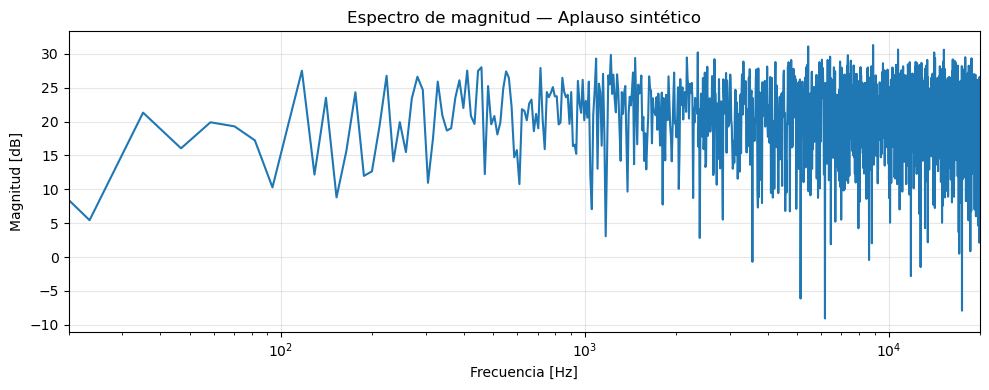

Ancho de banda efectivo (-20 dB): 0 Hz - 24000 Hz


In [5]:
# Análisis de características de la señal
import numpy as np
from scipy import signal as sp_signal

# Duración
duration_sec = len(clap) / sr
print(f"Duración de la señal: {duration_sec:.4f} segundos ({len(clap)} muestras)")

# Amplitud máxima y RMS
max_amp = np.max(np.abs(clap))
rms = np.sqrt(np.mean(clap**2))
print(f"Amplitud máxima: {max_amp:.4f}")
print(f"RMS (energía): {rms:.4f}")

# Espectro de magnitud
n_fft = 4096
freqs = np.fft.rfftfreq(n_fft, 1/sr)
spectrum = np.abs(np.fft.rfft(clap, n=n_fft))

# Frecuencia dominante
peak_idx = np.argmax(spectrum)
peak_freq = freqs[peak_idx]
print(f"Frecuencia con mayor energía: {peak_freq:.2f} Hz")

# Graficar espectro de magnitud
plt.figure(figsize=(10, 4))
plt.plot(freqs, 20*np.log10(spectrum + 1e-10))  # Convertir a dB
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('Espectro de magnitud — Aplauso sintético')
plt.xlim(20, 20000)
plt.xscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Ancho de banda efectivo (donde la energía es >-20 dB del máximo)
threshold = np.max(spectrum) * 0.1  # -20 dB
indices_above = np.where(spectrum > threshold)[0]
if len(indices_above) > 0:
    f_low = freqs[indices_above[0]]
    f_high = freqs[indices_above[-1]]
    print(f"Ancho de banda efectivo (-20 dB): {f_low:.0f} Hz - {f_high:.0f} Hz")

## 3. Respuesta al impulso (IR)

### 3.1 ¿Qué es IR?

La **Respuesta al Impulso** (IR, del inglés *Impulse Response*) es la salida de un sistema cuando se excita con un impulso unitario (delta de Dirac). En acústica, representa la caracterización completa de un espacio o sistema acústico lineal.

**Propiedades clave:**

1. **Caracterización completa del sistema**: La IR contiene toda la información sobre cómo el sistema responde a cualquier entrada.

2. **Información temporal**: 
   - **Sonido directo**: Primera llegada, sin reflexiones
   - **Reflexiones tempranas**: Primeras reflexiones en superficies (< 80 ms)
   - **Reverberación tardía**: Cola de decaimiento exponencial

3. **Información espectral**: La IR codifica cómo el espacio modifica cada frecuencia de manera diferente (absorción dependiente de frecuencia, resonancias, etc.).

**Tipos de IR en este proyecto:**

- **IR de salas simuladas** (pyroomacoustics):
  - Sala pequeña: 5×4×3 m, RT60 ≈ 0.3 s
  - Sala mediana: 10×8×4 m, RT60 ≈ 0.5 s  
  - Sala grande/Hall: 20×15×8 m, RT60 ≈ 1.2 s

- **IR de estructura escalonada** (modelo Pirámide/Quetzal):
  - Simulación de reflexiones en escalones periódicos
  - Genera el efecto "chirp" característico
  - Basado en el trabajo de Declercq et al. [1,2]



### 3.2 ¿Qué es la convolución?

La **convolución** es la operación matemática que combina dos señales para producir una tercera. En el contexto de la auralización acústica:

$$
\text{Señal auralizada} = \text{Señal seca} * \text{Respuesta al impulso}
$$

**Interpretación física:**

Cuando una señal **x[n]** (por ejemplo, un aplauso) se propaga en un espacio con IR **h[n]**, cada muestra de **x[n]** genera una copia escalada de **h[n]**. La salida **y[n]** es la superposición de todas estas copias retardadas:

$$
y[n] = \sum_{k=0}^{N-1} x[k] \cdot h[n-k]
$$


**Aplicaciones en este proyecto:**

1. **Auralización**: Simular cómo sonaría una fuente en un espacio específico
2. **Análisis de espacios**: Entender características acústicas mediante visualización de IR
3. **Validación del modelo**: Comparar audio simulado con grabaciones reales
4. **Diseño acústico**: Experimentar con diferentes geometrías y materiales

**Consideraciones prácticas:**

- **Normalización**: Es crucial normalizar la salida para evitar clipping (saturación digital)
- **Longitud de la convolución**: Si x[n] tiene longitud N y h[n] tiene longitud M, y[n] tendrá longitud N+M-1
- **Causalidad**: Las IR deben ser causales (h[n] = 0 para n < 0)
- **Filtrado adicional**: Se pueden aplicar filtros (EQ) antes o después de la convolución para ajustar el timbre

## 4. Implementación de la convolución

### 4.1 Importar Librerías y Módulos

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import importlib

In [7]:
# Agregar la carpeta src al path de Python
sys.path.insert(0, str(Path.cwd().parent / 'src'))

# Importar módulos personalizados
from audio_utils import (
    make_synthetic_clap,
    convolve_fft,
    play_audio, 
    save_audio,
    calculate_rms,
    calculate_peak
)

from ir_generator import (
    generate_preset_rooms,
    calculate_rt60
)

from visualization import (
    plot_waveform,
    plot_spectrogram,
    plot_comparison_waveforms,
    plot_comparison_spectrograms,
    plot_edc
)


Señal de prueba: Aplauso sintético


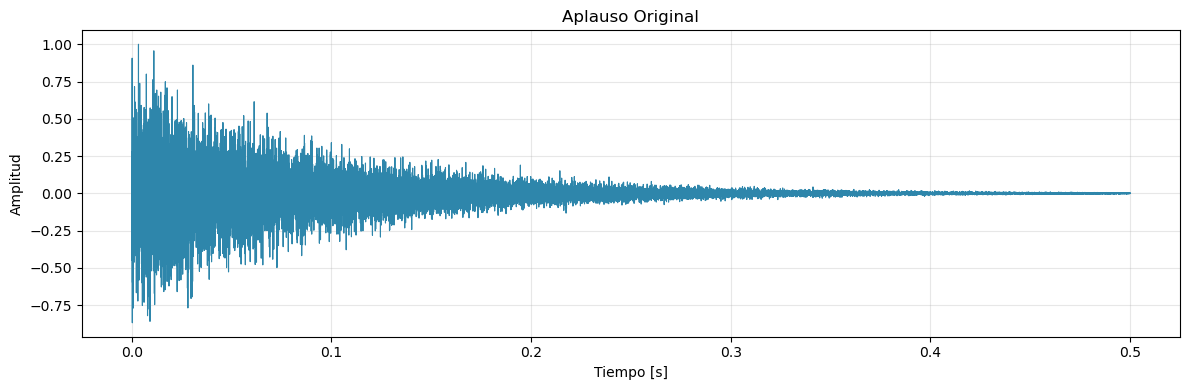

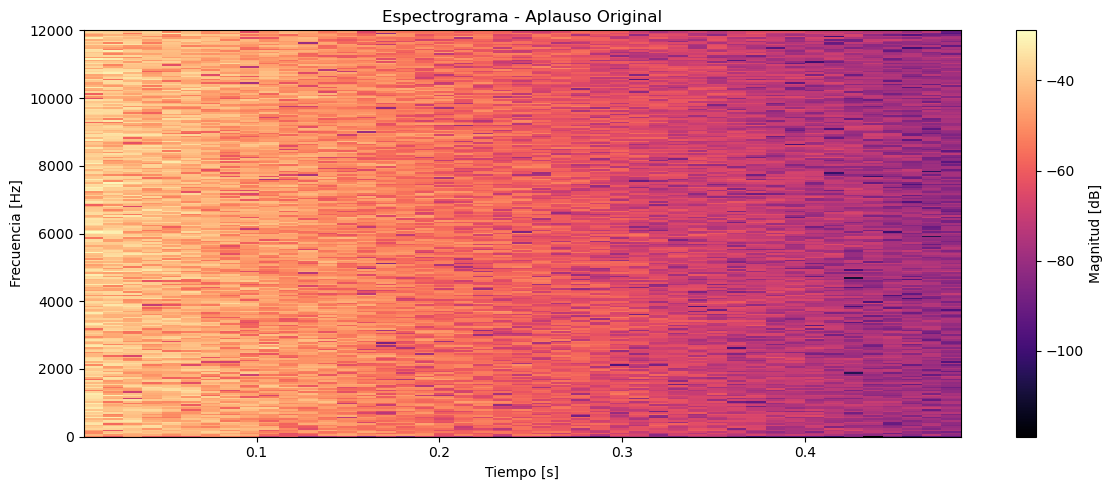

In [8]:
# Reproducir audio origial
print("Señal de prueba: Aplauso sintético")
play_audio(clap, sr)

plot_waveform(clap, sr, title='Aplauso Original', color='#2E86AB')
plot_spectrogram(clap, sr, title='Espectrograma - Aplauso Original')

### 4.2 Generar Respuestas al Impulso

In [9]:
print("\n" + "="*60)
print("GENERANDO RESPUESTAS AL IMPULSO")
print("="*60 + "\n")

irs, metadata = generate_preset_rooms(sr=sr)

# Mostrar información
print("="*60)
print("INFORMACIÓN DE LAS SALAS")
print("="*60)
for key, meta in metadata.items():
    ir = irs[key]
    rt60 = calculate_rt60(ir, sr)
    print(f"{meta['nombre']:<25} | {meta['dimensiones']:<12} | "
          f"Vol: {meta['volumen']:>5} m³ | RT60: {rt60:.3f}s")
print("="*60 + "\n")


GENERANDO RESPUESTAS AL IMPULSO

Generando IR: Sala Pequeña...
Generando IR: Sala Mediana...
Generando IR: Sala Grande (Hall)...
✓ IRs generadas correctamente

INFORMACIÓN DE LAS SALAS
Sala Pequeña              | 5×4×3 m      | Vol:    60 m³ | RT60: 0.000s
Sala Mediana              | 10×8×4 m     | Vol:   320 m³ | RT60: 0.000s
Sala Grande / Hall        | 20×15×8 m    | Vol:  2400 m³ | RT60: 0.000s



### 4.3 Aplicar Convolución

In [10]:
print("="*60)
print("APLICANDO CONVOLUCIÓN")
print("="*60 + "\n")

resultados = {}

for key in irs.keys():
    nombre = metadata[key]['nombre']
    print(f"Convolando: Aplauso + {nombre}...")
    resultados[key] = convolve_fft(clap, irs[key], normalize=True)
    print(f"  → Duración salida: {len(resultados[key])/sr:.3f}s\n")

print("✓ Convoluciones completadas\n")

APLICANDO CONVOLUCIÓN

Convolando: Aplauso + Sala Pequeña...
  → Duración salida: 1.700s

Convolando: Aplauso + Sala Mediana...
  → Duración salida: 2.000s

Convolando: Aplauso + Sala Grande / Hall...
  → Duración salida: 2.500s

✓ Convoluciones completadas



### 4.4 Visualización Individual

RESULTADO: SALA PEQUEÑA

🔊 Reproducir: Aplauso en Sala Pequeña


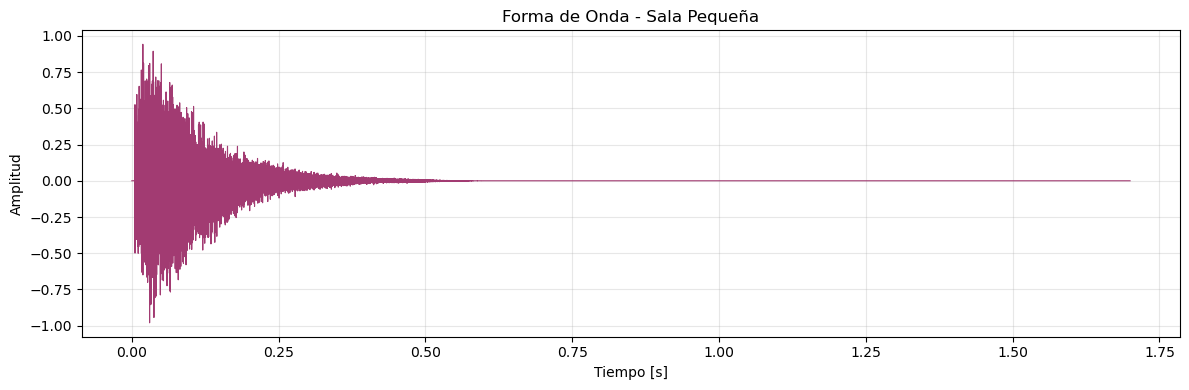

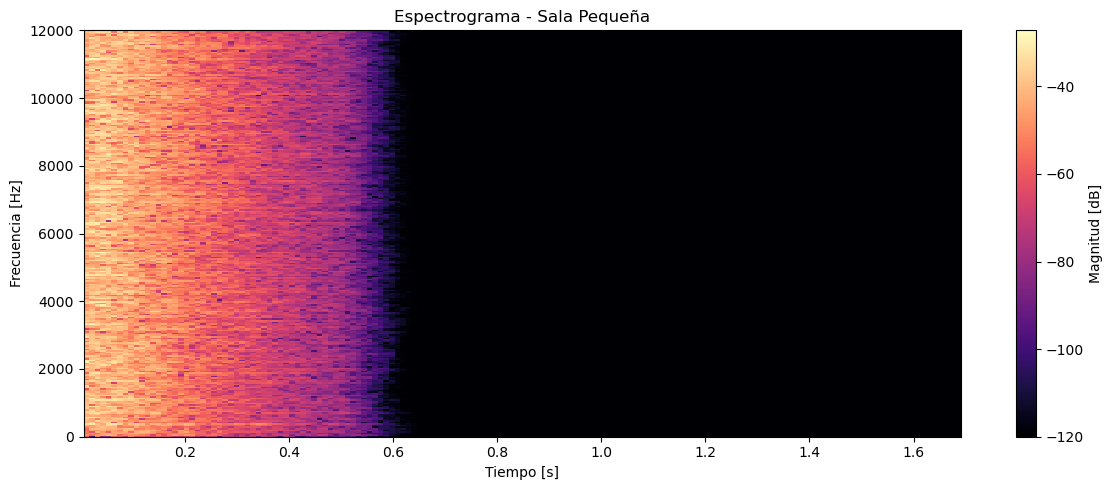

RESULTADO: SALA MEDIANA

🔊 Reproducir: Aplauso en Sala Mediana


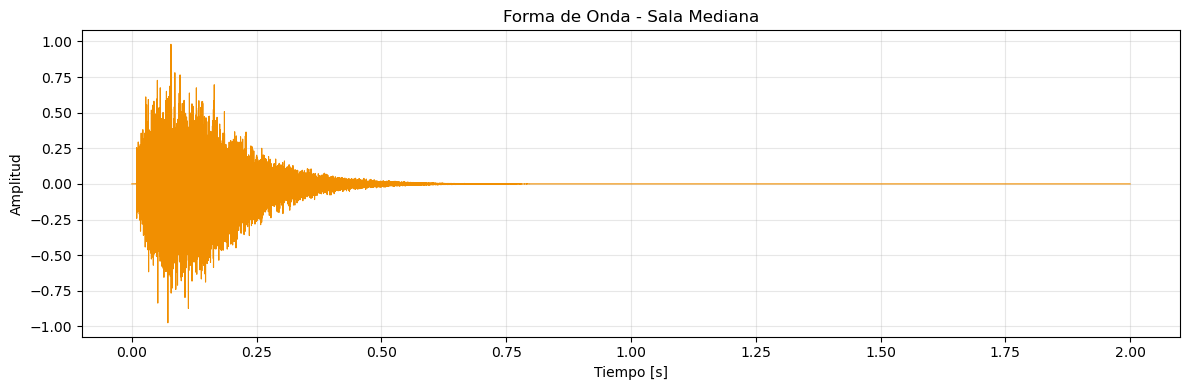

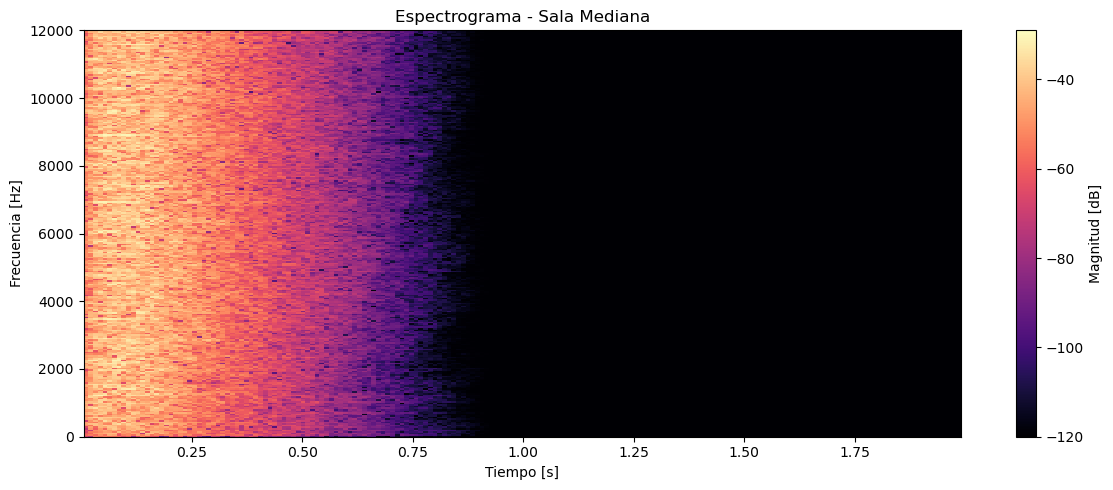

RESULTADO: SALA GRANDE / HALL

🔊 Reproducir: Aplauso en Sala Grande / Hall


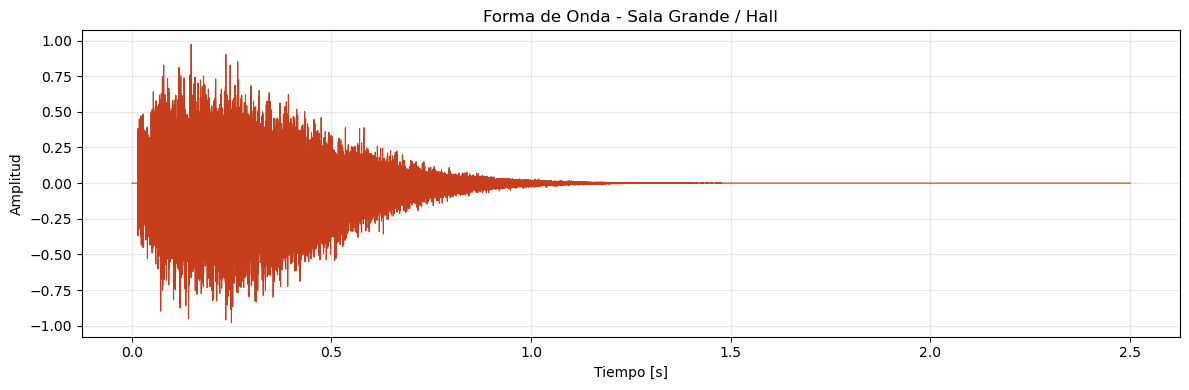

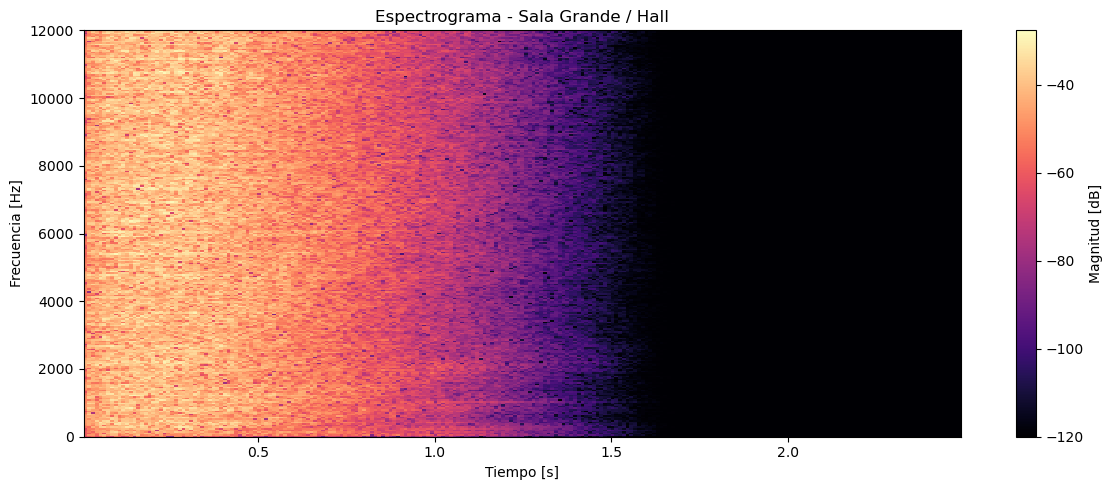

In [11]:
# Reproducir y visualizar cada resultado
for key in resultados.keys():
    nombre = metadata[key]['nombre']
    audio = resultados[key]
    color = metadata[key]['color']
    
    print("="*60)
    print(f"RESULTADO: {nombre.upper()}")
    print("="*60 + "\n")
    
    print(f"🔊 Reproducir: Aplauso en {nombre}")
    play_audio(audio, sr)
    
    plot_waveform(audio, sr, title=f'Forma de Onda - {nombre}', color=color)
    plot_spectrogram(audio, sr, title=f'Espectrograma - {nombre}')

### 4.5 Comparación Visual


COMPARACIÓN: FORMAS DE ONDA



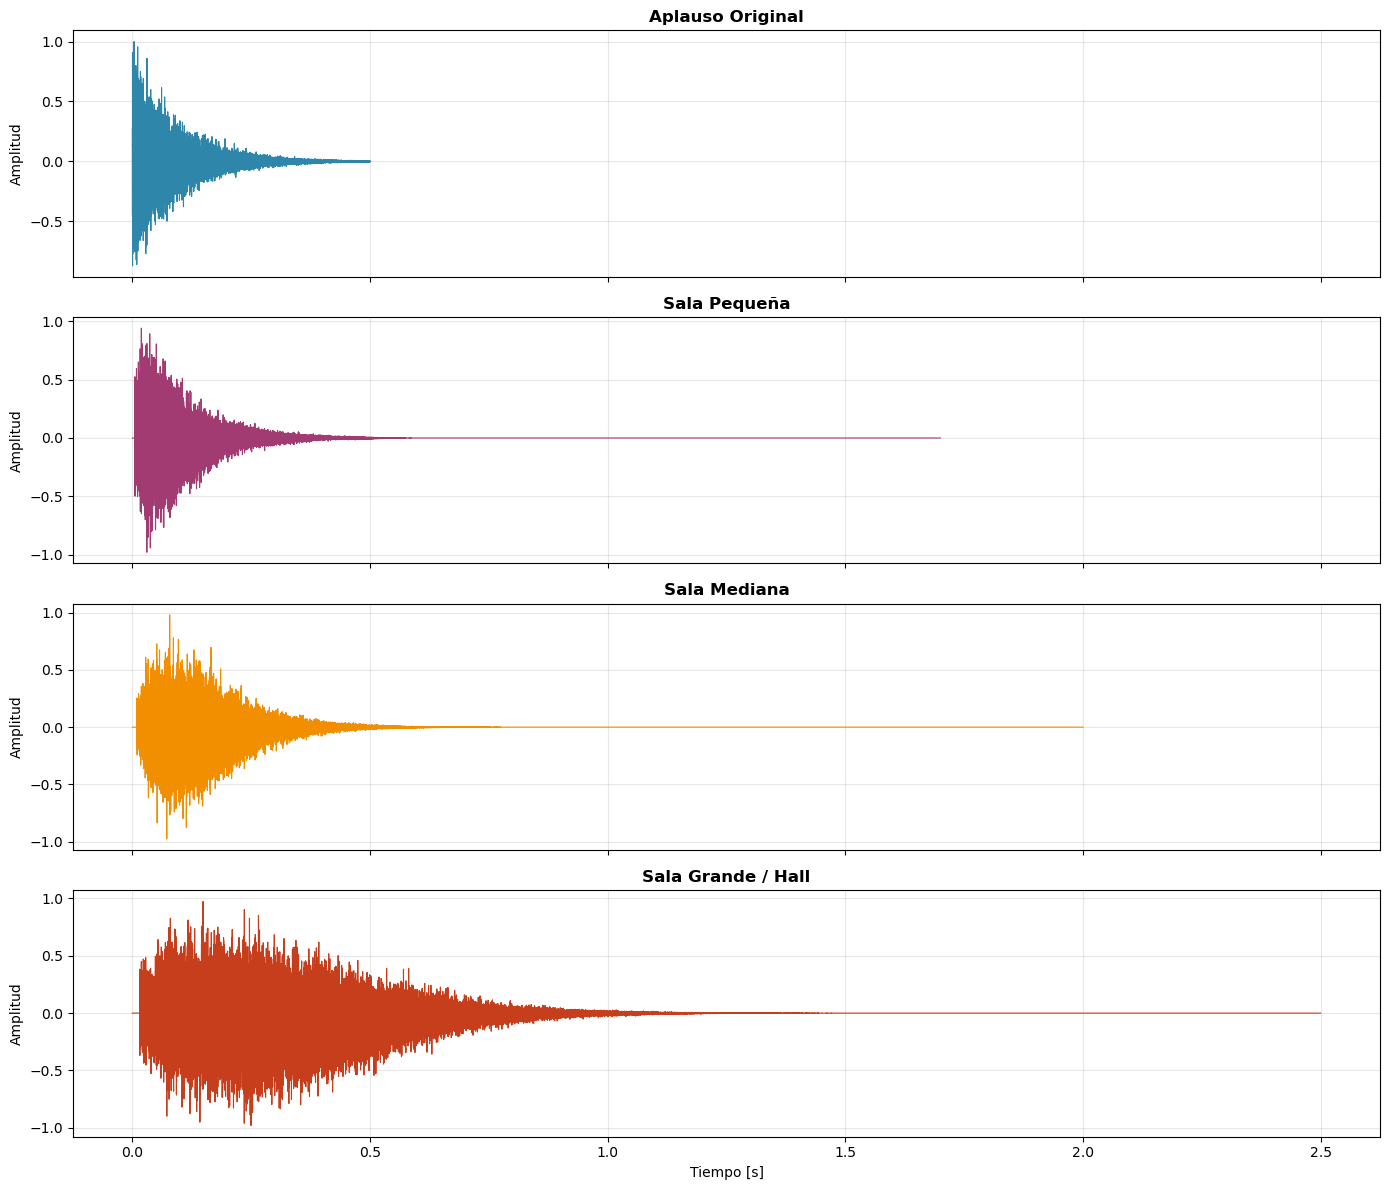

COMPARACIÓN: ESPECTROGRAMAS



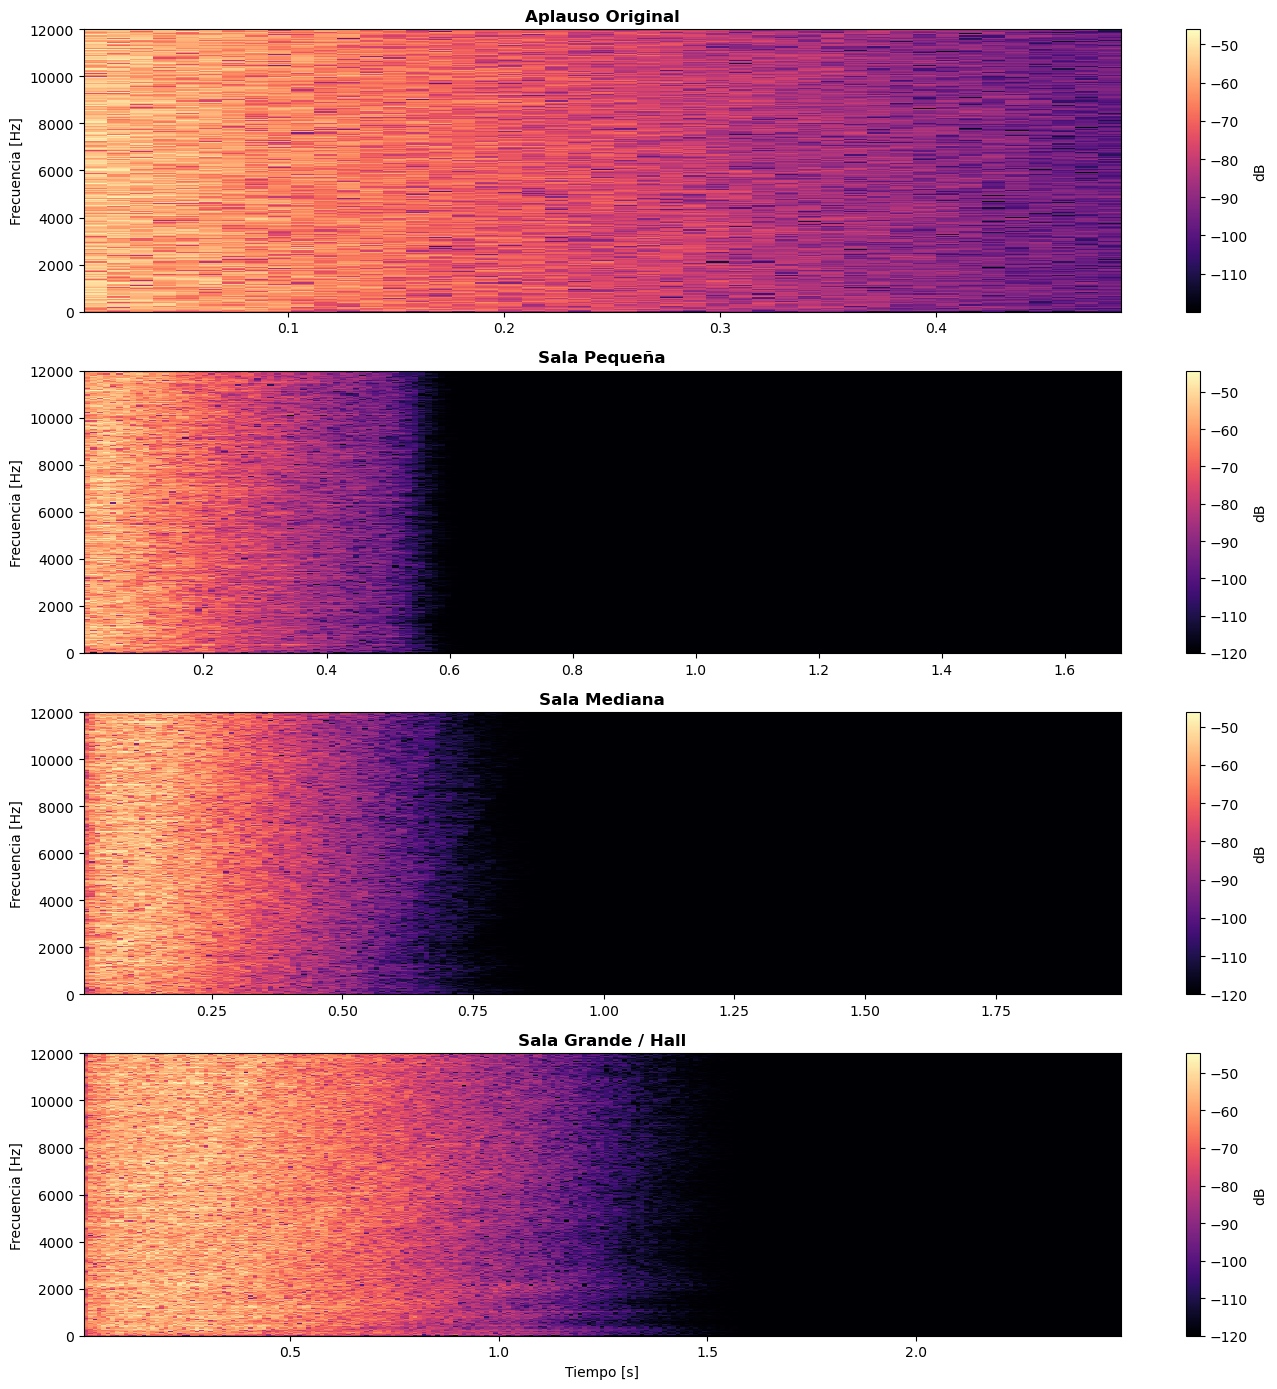

In [12]:
print("\n" + "="*60)
print("COMPARACIÓN: FORMAS DE ONDA")
print("="*60 + "\n")

# Preparar datos para comparación
signals = {'Aplauso Original': clap}
colors = {'Aplauso Original': '#2E86AB'}

for key in resultados.keys():
    nombre = metadata[key]['nombre']
    signals[nombre] = resultados[key]
    colors[nombre] = metadata[key]['color']

plot_comparison_waveforms(signals, sr, colors)

# %%
print("="*60)
print("COMPARACIÓN: ESPECTROGRAMAS")
print("="*60 + "\n")

plot_comparison_spectrograms(signals, sr)

## Implementación pŕactica

## Qué hace este prototipo
- Entradas: aplauso sintético, barrido senoidal o cargar WAV.
- Presets de IR: salas (pequeña/mediana/gran sala) y un modelo escalonado ‘Pirámide (Quetzal)’.
- Procesamiento: convolución FFT + normalización opcional + filtro simple (lowpass/highpass/bandpass).
- Salida: reproductor de audio, forma de onda, espectrograma y opción de exportar WAV a `hito2/data/outputs/`.

In [13]:
import os, time, math, textwrap
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import soundfile as sf
import ipywidgets as widgets
from IPython.display import Audio, display, clear_output
import pyroomacoustics as pra

plt.rcParams['figure.figsize'] = (10, 4)
DATA_DIR = Path('data')
IN_DIR = DATA_DIR / 'inputs'
OUT_DIR = DATA_DIR / 'outputs'
IN_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)
print('Entorno listo.')


Entorno listo.


In [14]:
# Utilidades de audio y visualización
def normalize_audio(x, peak=0.98):
    x = np.asarray(x, dtype=float)
    m = np.max(np.abs(x)) + 1e-12
    return (x / m) * peak

def resample_if_needed(x, sr, target_sr):
    if target_sr is None or sr == target_sr:
        return x, sr
    g = math.gcd(int(sr), int(target_sr))
    up = target_sr // g
    down = sr // g
    xr = signal.resample_poly(x, up, down)
    return xr.astype(float), target_sr

def load_audio(path, target_sr=None, mono=True):
    x, sr = sf.read(path, always_2d=False)
    if x.ndim > 1 and mono:
        x = x.mean(axis=1)
    x, sr = resample_if_needed(x, sr, target_sr)
    return x.astype(float), sr

def save_audio(path, x, sr):
    sf.write(str(path), x, int(sr))

def plot_waveform(x, sr, title='Señal'):
    t = np.arange(len(x)) / sr
    plt.figure()
    plt.plot(t, x, lw=0.9)
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Amplitud')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_spectrogram(x, sr, title='Espectrograma'):
    f, t, Sxx = signal.spectrogram(x, fs=sr, nperseg=1024, noverlap=512, scaling='spectrum')
    Sxx_db = 10 * np.log10(Sxx + 1e-12)
    plt.figure()
    plt.pcolormesh(t, f, Sxx_db, shading='auto', cmap='magma')
    plt.ylabel('Frecuencia [Hz]')
    plt.xlabel('Tiempo [s]')
    plt.ylim(0, sr/2)
    plt.title(title)
    plt.colorbar(label='dB')
    plt.tight_layout()
    plt.show()

def play(x, sr):
    display(Audio(x, rate=sr))

def make_synthetic_clap(sr=48000, duration_s=0.12, decay=3.5, noise_level=0.3):
    n = int(sr * duration_s)
    x = np.zeros(n)
    x[0] = 1.0  # impulso inicial
    rn = np.random.randn(n)
    env = np.exp(-np.linspace(0, decay, n))
    x += noise_level * rn * env
    return normalize_audio(x)

def make_sine_sweep(sr=48000, dur_s=2.0, f0=20.0, f1=12000.0):
    t = np.linspace(0, dur_s, int(sr*dur_s), endpoint=False)
    x = signal.chirp(t, f0=f0, f1=f1, t1=dur_s, method='logarithmic')
    win = signal.windows.tukey(len(x), alpha=0.1)
    return normalize_audio(x*win)

def butter_filter(x, sr, ftype='none', f_lo=200.0, f_hi=3000.0, order=4):
    x = np.asarray(x, dtype=float)
    nyq = 0.5 * sr
    f_lo = max(10.0, min(f_lo, nyq*0.99))
    f_hi = max(20.0, min(f_hi, nyq*0.99))
    if ftype == 'none':
        return x
    if ftype == 'lowpass':
        wn = min(f_hi/nyq, 0.999)
        b, a = signal.butter(order, wn, btype='low', output='ba')
    elif ftype == 'highpass':
        wn = max(f_lo/nyq, 1e-4)
        b, a = signal.butter(order, wn, btype='high', output='ba')
    elif ftype == 'bandpass':
        lo = max(1e-4, min(f_lo/nyq, 0.99))
        hi = max(lo*1.01, min(f_hi/nyq, 0.999))
        b, a = signal.butter(order, [lo, hi], btype='band', output='ba')
    else:
        return x
    return signal.lfilter(b, a, x)

def apply_ir(x, ir, normalize=True):
    y = signal.fftconvolve(x, ir, mode='full')
    return normalize_audio(y) if normalize else y


In [15]:
# Generación de IRs: sala (Pyroomacoustics) y estructura escalonada (‘Quetzal’)
def pad_to_length(x, n):
    if len(x) >= n:
        return x[:n]
    out = np.zeros(n)
    out[:len(x)] = x
    return out

def simulate_room_ir(
    sr=48000,
    room_dim=(8.0, 5.0, 3.0),
    absorption=0.2,
    max_order=10,
    src_pos=(2.0, 2.0, 1.5),
    mic_pos=(6.0, 3.0, 1.5),
    ir_length_s=1.2,
):
    materials = pra.Material(absorption)
    room = pra.ShoeBox(room_dim, fs=sr, materials=materials, max_order=max_order)
    room.add_source(src_pos)
    mic_locs = np.array(mic_pos).reshape(-1, 1)
    room.add_microphone_array(pra.MicrophoneArray(mic_locs, room.fs))
    room.compute_rir()
    ir = np.asarray(room.rir[0][0], dtype=float)
    N = int(sr * ir_length_s)
    ir = pad_to_length(ir, N)
    return normalize_audio(ir)

def stepped_structure_ir(
    sr=48000,
    base_delay_ms=6.0,   # primer retardo
    step_delta_ms=1.2,   # incremento de retardo por eco
    accel_ms=-0.03,      # curvatura temporal (chirp en tiempos)
    num_steps=45,        # cantidad de ecos
    decay=0.92,          # atenuación por paso
    ir_length_s=1.4,
):
    delays_ms = []
    for n in range(num_steps):
        t = base_delay_ms + n * step_delta_ms + 0.5 * accel_ms * n * (n - 1)
        if t >= 0:
            delays_ms.append(t)
    if not delays_ms:
        return np.array([1.0])
    max_delay_ms = max(delays_ms)
    N = int(sr * ir_length_s)
    L = max(N, int(sr * (max_delay_ms / 1000.0)) + sr // 10)
    ir = np.zeros(L)
    for i, t_ms in enumerate(delays_ms):
        idx = int(round(sr * (t_ms / 1000.0)))
        if idx < L:
            ir[idx] += decay ** i
    ir[0] += 0.05
    ir = ir[:N] if N < len(ir) else ir
    return normalize_audio(ir)

def get_preset_ir(preset, sr):
    preset = str(preset).lower().strip()
    if preset.startswith('sala pequeña'):
        ir = simulate_room_ir(sr=sr, room_dim=(4.0, 3.0, 2.5), absorption=0.45, max_order=8,
                            src_pos=(1.2,1.0,1.2), mic_pos=(3.2,1.8,1.2), ir_length_s=1.0)
        label = 'Sala pequeña'
    elif preset.startswith('sala mediana'):
        ir = simulate_room_ir(sr=sr, room_dim=(8.0, 5.5, 3.2), absorption=0.25, max_order=12,
                            src_pos=(2.0,2.3,1.5), mic_pos=(6.0,3.1,1.5), ir_length_s=1.2)
        label = 'Sala mediana'
    elif 'hall' in preset or 'grande' in preset:
        ir = simulate_room_ir(sr=sr, room_dim=(16.0, 11.0, 6.0), absorption=0.12, max_order=15,
                            src_pos=(4.0,3.0,2.0), mic_pos=(12.0,7.0,2.5), ir_length_s=1.6)
        label = 'Sala grande / Hall'
    else:
        ir = stepped_structure_ir(sr=sr)
        label = 'Pirámide (Quetzal)'
    return ir, label


In [16]:
# Interfaz interactiva con ipywidgets
# Controles
sr_dd = widgets.Dropdown(options=[48000, 44100], value=48000, description='Frecuencia de muestreo')
in_src = widgets.Dropdown(
    options=['Aplauso (sintético)', 'Barrido senoidal (20 Hz–12 kHz)', 'Cargar WAV (carpeta inputs)'],
    value='Aplauso (sintético)', description='Entrada'
)
wav_path = widgets.Text(value=str(IN_DIR / 'mi_audio.wav'), description='Ruta WAV', layout=widgets.Layout(width='50%'))

preset_dd = widgets.Dropdown(
    options=['Sala pequeña', 'Sala mediana', 'Sala grande / Hall', 'Pirámide (Quetzal) 🌪️'],
    value='Sala mediana', description='Preajuste de IR'
)

# Filtro de coloración (post-EQ)
eq_dd = widgets.Dropdown(options=['Ninguno', 'Pasa-bajos', 'Pasa-altos', 'Pasa-banda'], value='Ninguno', description='Filtro (posterior)')
f_lo = widgets.FloatSlider(value=200.0, min=20.0, max=5000.0, step=10.0, description='Frecuencia baja [Hz]')
f_hi = widgets.FloatSlider(value=3000.0, min=200.0, max=18000.0, step=10.0, description='Frecuencia alta [Hz]')
normalize_ck = widgets.Checkbox(value=True, description='Normalizar')

render_btn = widgets.Button(description='Procesar', button_style='primary')
save_btn = widgets.Button(description='Exportar WAV', button_style='')
out = widgets.Output()

state = {'y': None, 'sr': None, 'label': None, 'busy': False}

def _slug(s):
    return ''.join(ch for ch in s.lower() if ch.isalnum() or ch in ('-', '_')).replace(' ', '_')

def do_render(_=None):
    if state.get('busy'):
        return
    state['busy'] = True
    render_btn.disabled = True
    try:
        sr = int(sr_dd.value)
        # Entrada
        if in_src.value.startswith('Aplauso'):
            x = make_synthetic_clap(sr=sr)
        elif in_src.value.startswith('Barrido senoidal'):
            x = make_sine_sweep(sr=sr)
        else:
            x, _sr = load_audio(wav_path.value, target_sr=sr)
        # IR
        ir, label = get_preset_ir(preset_dd.value, sr)
        # Convolución
        y = apply_ir(x, ir, normalize=normalize_ck.value)
        # Post-EQ
        eq_mode = eq_dd.value.lower()
        if eq_mode != 'ninguno':
            mode_map = {'pasa-bajos': 'lowpass', 'pasa-altos': 'highpass', 'pasa-banda': 'bandpass'}
            y = butter_filter(y, sr, ftype=mode_map.get(eq_mode, 'none'), f_lo=f_lo.value, f_hi=f_hi.value, order=4)
            if normalize_ck.value:
                y = normalize_audio(y)
        # Estado para exportar
        state['y'] = y
        state['sr'] = sr
        state['label'] = label
        # Mostrar
        with out:
            clear_output(wait=True)
            print(f'Entrada: {in_src.value} | IR: {label} | Frecuencia de muestreo: {sr} Hz')
            print('— Señal de entrada')
            play(x, sr)
            print('— Respuesta al impulso (escuchar a bajo volumen)')
            play(ir, sr)
            print('— Señal de salida (convolución)')
            play(y, sr)
            plot_waveform(y, sr, title='Salida — forma de onda')
            plot_spectrogram(y, sr, title='Salida — espectrograma')
    finally:
        state['busy'] = False
        render_btn.disabled = False

def do_save(_=None):
    y = state.get('y'); sr = state.get('sr'); label = state.get('label') or 'out'
    if y is None or sr is None:
        with out: print('No hay resultado para exportar. Pulsa Procesar primero.')
        return
    fname = f'out_{_slug(label)}_{int(time.time())}.wav'
    fpath = OUT_DIR / fname
    save_audio(fpath, y, sr)
    with out: print('Exportado:', fpath)

# Evitar callbacks duplicados si se re-ejecuta la celda
try:
    render_btn._click_handlers.callbacks.clear()
    save_btn._click_handlers.callbacks.clear()
except Exception:
    pass
render_btn.on_click(do_render)
save_btn.on_click(do_save)

ui_top = widgets.HBox([sr_dd, in_src])
ui_path = widgets.HBox([wav_path])
ui_preset = widgets.HBox([preset_dd])
ui_eq = widgets.HBox([eq_dd, f_lo, f_hi, normalize_ck])
ui_btns = widgets.HBox([render_btn, save_btn])
ui = widgets.VBox([ui_top, ui_path, ui_preset, ui_eq, ui_btns, out])
display(ui)
